In [1]:
from helper.dataset_reader import read_tsv
from helper.data_transformer import *
#from helper.utils import *
from ner_crf_2 import *
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn_crfsuite import metrics

In [2]:
ner = NamedEntityRecognition()

In [3]:
#merged_data = read_tsv('../dataset/comlid-data-140422-v1.tsv')

train_data = read_tsv('../dataset/train.tsv')
val_data = read_tsv('../dataset/val.tsv')
test_data = read_tsv('../dataset/test.tsv')

In [4]:
train_data = to_token_tag_list(train_data)
val_data = to_token_tag_list(val_data)
test_data = to_token_tag_list(test_data)

In [5]:
def get_features(data):
	X = [ner.sent2features(s) for s in data]
	y = [ner.sent2tags(s) for s in data]

	return X, y

In [6]:
X_train, y_train = get_features(train_data)
X_val, y_val = get_features(val_data)
X_test, y_test = get_features(test_data)

In [7]:
print(f"Train set: {len(X_train)} sentences")
print(f"Val set: {len(X_val)} sentences")
print(f"Test set: {len(X_test)} sentences")

Train set: 4556 sentences
Val set: 1139 sentences
Test set: 2805 sentences


### CRF Training

In [8]:
model = sklearn_crfsuite.CRF(
	algorithm='lbfgs',
	max_iterations=100,
	all_possible_transitions=True,
	c1=0.1,  # Coefficient for Lasso (L1) regularization for
    c2=0.1,  # Coefficient for Ridge (L2) regularization
)

In [9]:
# train CRF
%time
model.fit(X=X_train, y=y_train, X_dev=X_val, y_dev=y_val)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

In [10]:
y_pred = model.predict(X_test)

In [11]:
# save model
model_name = 'crf_model_split_2.pkl'
root_path = 'model/'
joined_path = os.path.join(root_path, model_name)
pickle.dump(model, open(joined_path, 'wb'))


 Evaluation on the test data
Confusion Matrix
              precision    recall  f1-score   support

           O     0.9972    0.9984    0.9978     56762
   I-PURPOSE     0.9421    0.9810    0.9612       946
  I-HERITAGE     0.9468    0.9873    0.9666       631
   I-NATURAL     0.9500    0.9818    0.9656       658
   B-PURPOSE     0.9852    0.9077    0.9448       585
  B-HERITAGE     0.9898    0.8940    0.9395       434
   B-NATURAL     0.9854    0.8754    0.9272       618

    accuracy                         0.9950     60634
   macro avg     0.9709    0.9465    0.9575     60634
weighted avg     0.9950    0.9950    0.9949     60634



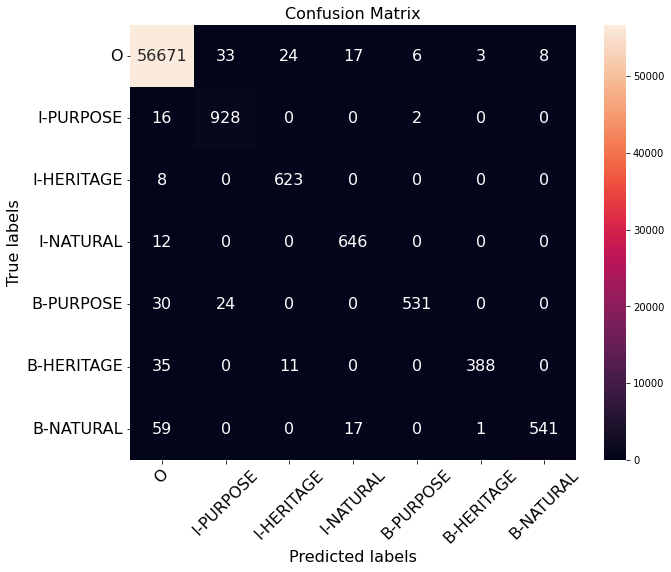

In [12]:
print('\n Evaluation on the test data')
ner.show_confusion_matrix(y_test, y_pred)

# increase font of x and y axis

In [13]:
print("\nTop likely transitions:")
ner.print_transitions(Counter(model.transition_features_).most_common(20))
print("\nTop unlikely transitions:")
ner.print_transitions(Counter(model.transition_features_).most_common()[-20:])

# check the state features
print("\nTop positive:")
ner.print_state_features(Counter(model.state_features_).most_common(20))
print("\nTop negative:")
ner.print_state_features(Counter(model.state_features_).most_common()[-20:])


Top likely transitions:
B-PURPOSE  -> I-PURPOSE  3.00385
O          -> O          2.84941
B-HERITAGE -> I-HERITAGE 2.83406
B-NATURAL  -> I-NATURAL  2.82875
O          -> B-PURPOSE  2.66443
I-PURPOSE  -> I-PURPOSE  2.48860
I-NATURAL  -> I-NATURAL  2.37504
O          -> B-HERITAGE 2.36545
O          -> B-NATURAL  2.33898
I-HERITAGE -> I-HERITAGE 1.64312
I-PURPOSE  -> O          0.38031
I-HERITAGE -> O          0.32308
I-NATURAL  -> O          0.31511
O          -> I-NATURAL  0.27976
B-HERITAGE -> O          0.11633
B-PURPOSE  -> O          0.07946
B-NATURAL  -> O          0.03153
B-NATURAL  -> B-NATURAL  -0.04165
I-HERITAGE -> B-HERITAGE -0.08921
I-PURPOSE  -> B-PURPOSE  -0.11237

Top unlikely transitions:
I-HERITAGE -> B-NATURAL  -0.83325
I-HERITAGE -> I-NATURAL  -0.86152
B-PURPOSE  -> B-HERITAGE -0.86573
B-HERITAGE -> B-PURPOSE  -0.89615
B-NATURAL  -> B-HERITAGE -0.94047
B-PURPOSE  -> I-NATURAL  -0.94198
I-PURPOSE  -> B-NATURAL  -0.97754
B-PURPOSE  -> I-HERITAGE -1.00314
I-PURPOSE  ->

In [14]:
import eli5

eli5.show_weights(model,horizontal_layout=False, show=['transition_features'])

From \ To,O,B-HERITAGE,I-HERITAGE,B-NATURAL,I-NATURAL,B-PURPOSE,I-PURPOSE
O,2.849,2.365,-1.59,2.339,0.28,2.664,0.0
B-HERITAGE,0.116,-1.274,2.834,-1.139,-1.121,-0.896,-1.609
I-HERITAGE,0.323,-0.089,1.643,-0.833,-0.862,0.0,-1.349
B-NATURAL,0.032,-0.94,-1.095,-0.042,2.829,-1.082,-1.228
I-NATURAL,0.315,-0.639,-0.263,-0.288,2.375,-0.296,-1.221
B-PURPOSE,0.079,-0.866,-1.003,-0.595,-0.942,-0.403,3.004
I-PURPOSE,0.38,-0.443,-1.237,-0.978,-1.066,-0.112,2.489


In [15]:
eli5.show_weights(model, targets=['O','B-HERITAGE','I-HERITAGE'])

In [16]:
eli5.show_weights(model, targets=['B-NATURAL','I-NATURAL','B-PURPOSE','I-PURPOSE'])